In [2]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
def preprocess_data(file_path):
    """
    读取 CSV 数据，并对数据进行清洗和特征工程处理，返回处理后的 DataFrame。
    """
    # 读取 CSV 文件
    df = pd.read_csv(file_path)
    
    # 1. 删除重复值
    df = df.drop_duplicates()
    
    # 2. 删除完全为空的列
    df = df.dropna(axis=1, how='all')
    
    # 3. 删除存在信息泄露风险的字段
    leakage_cols = ['房屋优势', '核心卖点', '周边配套', '交通出行', '房屋年限', '房屋用途', '产权所属', '年份', '上次交易']
    df.drop(columns=[col for col in leakage_cols if col in df.columns], inplace=True)
    
    # 删除缺失率较高的列（缺失约50%或以上）
    NA_cols = ['套内面积', '别墅类型', '户型介绍', '环线']
    df.drop(columns=[col for col in NA_cols if col in df.columns], inplace=True)
    
    # 5. 清洗建筑面积字段（去掉“㎡”符号，并转换为浮点型）
    df['建筑面积'] = df['建筑面积'].str.replace('㎡', '', regex=False).astype(float)
    
    # 6. 删除不用于建模的文本型描述列
    drop_cols = ['小区名称', '所在楼层', '梯户比例', '交易权属', 'lon', 'lat']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    
    #对交易时间进行处理
    # 1. 确保交易时间是 datetime 类型
    df['交易时间'] = pd.to_datetime(df['交易时间'], errors='coerce')
    # 2. 提取年份并作为新的一列
    df['交易年份'] = df['交易时间'].dt.year
    # 2017~2024

    df = df.drop(columns=['交易时间'])

    # 处理缺失值
    df['装修情况'] = df['装修情况'].fillna('其他')
    df['配备电梯'] = df['配备电梯'].fillna('无')
    df['建筑结构'] = df['建筑结构'].fillna('钢混结构')  # 默认填充为“钢混结构”
    
    # 对房屋户型进行处理：提取“室数”
    df['室数'] = df['房屋户型'].str.extract(r'^(\d+)(?=[\u4e00-\u9fa5])')[0].astype('Int64')
    
    # 确保建筑面积为数值型
    df['建筑面积'] = pd.to_numeric(df['建筑面积'], errors='coerce')
    
    # 根据房屋户型计算每个室数对应的建筑面积中位数
    median_area_by_room = df.groupby('室数')['建筑面积'].median()
    print("每个室数的建筑面积中位数：")
    print(median_area_by_room)
    median_df = median_area_by_room.reset_index().sort_values('建筑面积').reset_index(drop=True)
    
    # 定义一个函数：根据建筑面积推断室数
    def infer_room_count(area):
        for i in range(len(median_df) - 1):
            low_area = median_df.loc[i, '建筑面积']
            high_area = median_df.loc[i + 1, '建筑面积']
            if low_area <= area < high_area:
                return median_df.loc[i, '室数']  # 取较小那一侧的室数
        # 大于最大值，取最大室数
        if area >= median_df['建筑面积'].iloc[-1]:
            return median_df['室数'].iloc[-1]
        # 小于最小值，取最小室数
        if area < median_df['建筑面积'].iloc[0]:
            return median_df['室数'].iloc[0]
        return np.nan
    
    # 对室数为空且建筑面积不为空的行，根据建筑面积进行填充
    mask = df['室数'].isna() & df['建筑面积'].notna()
    df.loc[mask, '室数'] = df.loc[mask, '建筑面积'].apply(infer_room_count)
    # 填充完毕后删除房屋户型字段
    df = df.drop(columns=['房屋户型'])
    

    # 对配备电梯进行编码（有：1，无：0）
    df['配备电梯'] = df['配备电梯'].map({'有': 1, '无': 0})
    
    # 对建筑结构和装修情况进行映射，后续使用 One-Hot 编码
    df['建筑结构编码'] = df['建筑结构'].map({'混合结构': '混合结构', '钢混结构': '钢混结构'}).fillna('其他')
    df['装修编码'] = df['装修情况'].map({'简装': '简装', '精装': '精装'}).fillna('其他')
    
    # 对建筑结构编码、装修编码和城市进行 One-Hot 编码（drop_first 避免多重共线性）
    onehot_cols = ['建筑结构编码', '装修编码', '城市']
    df = pd.get_dummies(df, columns=[col for col in onehot_cols if col in df.columns], drop_first=True)
    
    # 房屋朝向处理：构造一个简单的朝向编码函数
    def 朝向编码(x):
        if pd.isna(x):
            return 0
        # 当朝向中包含“南”或“东”且不包含“西”，则编码为1
        if ('南' in x or '东' in x) and ('西' not in x):
            return 1
        return 0
    df['朝向编码'] = df['房屋朝向'].apply(朝向编码)
    
    # 如果需要对高基数分类特征（比如“区域”、“板块”）做 Target Encoding，
    # 并且目标变量（比如 log_价格）存在，则可以执行下面代码：
    

    if '价格' in df.columns:
        #设置平均价格变量
        df['平均价格'] = df['价格'] / df['建筑面积']
        df['log_价格'] = np.log1p(df['平均价格'])
    #     target_enc = TargetEncoder(cols=['区域', '板块','交易年份'])
    #     df[['区域', '板块','交易年份']] = target_enc.fit_transform(df[['区域', '板块','交易年份']], df['log_价格'])
    #     df[['区域', '板块']] = target_enc.fit_transform(df[['区域', '板块']], df['log_价格'])
    #     df['平均价格'] = np.log1p(df['价格'] / df['建筑面积'])
    #     df['交易年份'] = target_enc.fit_transform(df['交易年份'], df['平均价格'])

    # 要标准化的列
    #cols_to_scale = ['建筑面积', '室数']

    # 1. 先保存原始建筑面积
    df['建筑面积ori'] = df['建筑面积']

    # 2. 标准化“建筑面积”列
    scaler_standard = StandardScaler()
    df['建筑面积'] = scaler_standard.fit_transform(df[['建筑面积']])
    drop_cols = ['房屋朝向', '建筑结构', '装修情况']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    return df


In [1]:
# 使用示例：
file_path = r'ruc_Class25Q1_train.csv'
df = preprocess_data(file_path)
print("处理后的数据预览：")
print(df.head())


NameError: name 'preprocess_data' is not defined

In [ ]:
# 使用示例：
file_path = r'ruc_Class25Q1_test.csv'
test_data = preprocess_data(file_path)
print("处理后的数据预览：")
print(test_data.head())

每个室数的建筑面积中位数：
室数
0     55.31
1     48.32
2     77.89
3    104.28
4    143.00
5    205.51
6    243.00
7    296.77
8    313.48
Name: 建筑面积, dtype: float64
处理后的数据预览：
   ID    区域     板块      建筑面积  配备电梯  交易年份  室数  建筑结构编码_混合结构  建筑结构编码_钢混结构  \
0   0  45.0  416.0  2.924011     1  2024   3        False         True   
1   1  45.0  414.0  1.783773     1  2024   4        False         True   
2   2  43.0  289.0  0.261200     1  2024   2        False         True   
3   3  39.0  374.0  0.430069     0  2024   3         True        False   
4   4  79.0  724.0 -0.884299     0  2024   2         True        False   

   装修编码_简装  装修编码_精装   城市_1   城市_2   城市_3   城市_4   城市_5   城市_6  朝向编码  建筑面积ori  
0    False     True  False  False  False  False  False  False     1   209.20  
1    False     True  False  False  False  False  False  False     1   163.69  
2     True    False  False  False  False  False  False  False     0   102.92  
3    False    False  False  False  False  False  False  False     1   109.66 

剔除异常值（建筑面积在三倍标准差之外，室数大于等于10）

In [ ]:
# # 计算建筑面积ori的均值和标准差
# mean_area = df['建筑面积ori'].mean()
# std_area = df['建筑面积ori'].std()

# # 条件1：建筑面积在合理范围内（±3σ）
# condition_area = (df['建筑面积ori'] >= mean_area - 3 * std_area) & (df['建筑面积ori'] <= mean_area + 3 * std_area)

# # 条件2：室数小于10
# condition_room = df['室数'] < 10

# # 组合条件：同时满足两个条件的保留
# df = df[condition_area & condition_room].reset_index(drop=True)


In [ ]:
# 2. 对高基数分类特征（区域、板块）进行 Target Encoding
#    训练集：fit_transform，需要使用目标变量 log_价格
target_enc = TargetEncoder(cols=['区域', '板块','交易年份'])
df[['区域', '板块','交易年份']] = target_enc.fit_transform(df[['区域', '板块','交易年份']], df['log_价格'])
#    测试集：直接 transform（测试集没有价格信息）
test_data[['区域', '板块','交易年份']] = target_enc.transform(test_data[['区域', '板块','交易年份']])

# 3. 对 Target Encoding 后的区域和板块进行归一化到 [-1,1]
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
df[['区域', '板块','交易年份']] = minmax_scaler.fit_transform(df[['区域', '板块','交易年份']])
test_data[['区域', '板块','交易年份']] = minmax_scaler.transform(test_data[['区域', '板块','交易年份']])

# 创建交互项变量：板块 × 交易年份
df['区域_交易年份'] = df['区域'] * df['交易年份']
    # 添加其他交互项
df['面积_室数'] = df['建筑面积'] * df['室数']
df['面积_区域'] = df['建筑面积'] * df['区域']

# 创建交互项变量：板块 × 交易年份
test_data['区域_交易年份'] = test_data['区域'] * test_data['交易年份']
        # 添加其他交互项
test_data['面积_室数'] = test_data['建筑面积'] * test_data['室数']
test_data['面积_区域'] = test_data['建筑面积'] * test_data['区域']

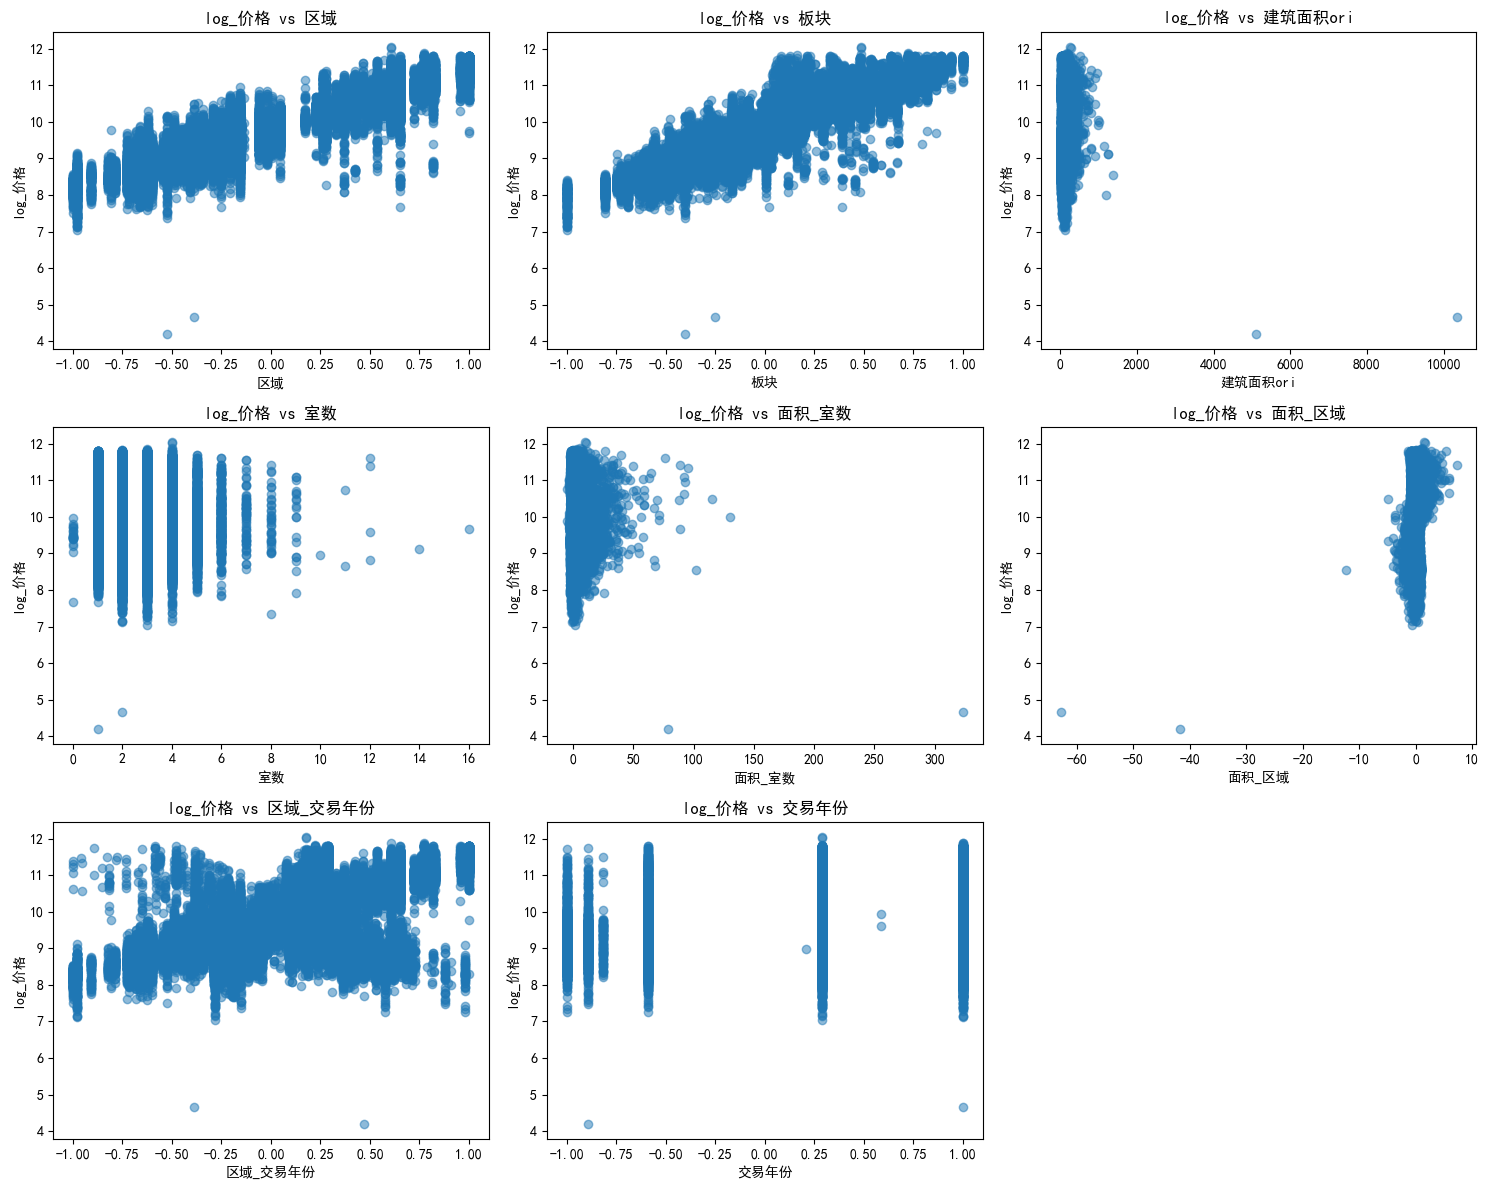

In [ ]:


import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'  # 黑体，支持中文（Windows）
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 设定参数
features = ['区域', '板块', '建筑面积ori',  '室数'
                     , '面积_室数', '面积_区域', '区域_交易年份','交易年份']

target = 'log_价格'

# 设置子图网格行列数（比如每行3列）
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

# 设置画布大小
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# 循环绘图
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(df[feature], df[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'{target} vs {feature}')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

#划分训练集与测试集（80%，20%）
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=111)

# 显示使用数据量
total_samples = len(train_df) + len(test_df)
print("共使用数据量：", total_samples, "条（训练集：", len(train_df), "，测试集：", len(test_df), "）")


all_features =['区域', '板块', '建筑面积', '配备电梯', '交易年份', '室数',
               '建筑结构编码_混合结构', '建筑结构编码_钢混结构', '装修编码_简装', '装修编码_精装', '城市_1', 
               '城市_2', '城市_3', '城市_4', '城市_5', '城市_6', '朝向编码', '区域_交易年份', '面积_室数','面积_区域']

selected_features =['区域', '板块', '建筑面积', '配备电梯',  '室数',
               '建筑结构编码_混合结构', '建筑结构编码_钢混结构', '装修编码_简装', '装修编码_精装', '城市_1', 
               '城市_2', '城市_3', '城市_4', '城市_5', '城市_6', '朝向编码','面积_室数','面积_区域', '区域_交易年份']
# 因变量
y_train = train_df['log_价格']
y_test = test_df['log_价格']

X_train = train_df[selected_features]
X_test = test_df[selected_features]

#LinearRegression()
#Ridge(alpha=0.1)
#Lasso(alpha=0.1)

# 1. 初始化并训练模型
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

# 2. 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 3. 模型评估
# 训练集评估
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# 测试集评估
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 定义 6 折交叉验证器
cv = KFold(n_splits=6, shuffle=True, random_state=111)

# R² 分数（默认）
cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv_mae = cross_val_score(model, X_train, y_train, cv=cv, scoring=mae_scorer)

# RMSE（自定义 scorer）
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
cv_rmse = cross_val_score(model, X_train, y_train, cv=cv, scoring=rmse_scorer)


# 4. 打印评估结果
print("训练集 R²：", train_r2)
print("训练集 RMSE：", train_rmse)
print("测试集 R²：", test_r2)
print("测试集 RMSE：", test_rmse)
print("交叉验证 R²：", np.mean(cv_r2))
print("交叉验证 MAE：", -np.mean(cv_mae))  # 取负号还原 MAE 正数
print("交叉验证 RMSE：", -np.mean(cv_rmse))  # 取负号还原 RMSE 正数

共使用数据量： 84062 条（训练集： 67249 ，测试集： 16813 ）
训练集 R²： 0.8963856671290983
训练集 RMSE： 0.24591447583585854
测试集 R²： 0.8933908106541333
测试集 RMSE： 0.250206258642857
交叉验证 R²： 0.8961377887959542
交叉验证 MAE： 0.1758692833223144
交叉验证 RMSE： 0.24616902975296714


In [ ]:
import numpy as np
import pandas as pd

# 1. 移除不用于模型预测的 ID 列（保留一份用于输出）
id_col = test_data['ID'].copy()
test_features = test_data.drop(columns=['ID'])
test_features=test_features[selected_features]
# 2. 使用训练好的模型进行预测（模型预测的是 log_价格）
pred_log_price = model.predict(test_features)

# 3. 将预测的 log_价格 还原为原始价格
pred_price = np.exp(pred_log_price) * test_data['建筑面积ori']

# 4. 将预测价格转换为整数
pred_price_int = np.round(pred_price).astype(int)

# 5. 构造结果 DataFrame
submission = pd.DataFrame({
    'ID': id_col,
    'Price': pred_price_int
})

# 6. 保存为 CSV 文件
submission.to_csv("prediction_lasso.csv", index=False)
print("预测结果已保存到 prediction_lasso.csv")


预测结果已保存到 prediction_lasso.csv
